In [8]:
from imports import *


In [12]:
query = "select * from train_data"
train_data = sql_connect(query)
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data['TARGET']
del train_data
X_train.head()

Connection to SQL Server established successfully.
Connection closed.


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
0,Cash loans,M,0,1,1,126000.0,545040.0,17244.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010966,-9470,-1114,-9301.0,-2142.0,-1,1,1,0,1,1,0,Drivers,3,2,2,TUESDAY,15,0,0,0,0,1,1,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.5739,0,0,0,0,0,0
1,Cash loans,F,0,1,0,135000.0,269550.0,18760.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.035792,-24367,365243,-13226.0,-4579.0,-1,1,0,0,1,1,0,Retired,2,2,2,WEDNESDAY,15,0,0,0,0,0,0,NA,0,0,0,0,-1052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.7012,0,0,0,0,0,1
2,Cash loans,M,0,0,0,270000.0,497520.0,33246.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008474,-10739,-353,-1418.0,-1843.0,-1,1,1,1,1,0,0,Laborers,2,2,2,SUNDAY,11,1,1,0,1,1,0,Business Entity Type 2,0,0,0,0,-251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.3572,0,0,0,0,0,0
3,Revolving loans,F,0,1,0,112500.0,315000.0,15750.0,315000.0,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,0.035792,-21202,365243,-15132.0,-3152.0,-1,1,0,0,1,1,0,Retired,1,2,2,SATURDAY,11,0,0,0,0,0,0,NA,0,0,0,0,-551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,8.0,0.5516,0,0,0,0,0,0
4,Revolving loans,F,1,1,2,225000.0,450000.0,22500.0,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.028663,-12341,-4904,-6217.0,-4151.0,24,1,1,0,1,0,0,Accountants,4,2,2,WEDNESDAY,11,0,0,0,1,0,1,Business Entity Type 2,0,0,0,0,-292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.4927,0,0,0,0,0,0


### 🧠 Insights from Exploratory Data Analysis (EDA)

- **Class Imbalance**  
  The target variable exhibits class imbalance, which may negatively affect model performance.  
  🔧 *Action*: Apply resampling techniques such as SMOTE or undersampling, or use evaluation metrics robust to imbalance (e.g., AUC, F1-score).

- **Skewed Feature Distributions**  
  Several features are highly skewed. Log transformation has been applied to reduce skewness and stabilize variance.

- **Varied Feature Scales**  
  Features are on different scales, which can affect distance-based models.  
  🔧 *Action*: Apply feature scaling.

- **High Dimensionality and Multicollinearity**  
  The dataset has a large number of features, increasing the risk of multicollinearity and overfitting.  
  🔧 *Action*: Use dimensionality reduction techniques like PCA or apply feature selection. Regularized models like Ridge and Lasso can also help.

---

Proceeding to modeling...


### Modeling Plan

We will train and evaluate **5 different logistic regression-based models** to understand the impact of preprocessing and regularization techniques:

---

1. **Model 1: Logistic Regression (All Features)**  
   - A simple baseline model using all raw features.  
   - Risk: May suffer from multicollinearity and overfitting due to unscaled and skewed inputs.

2. **Model 2: Logistic Regression (Log-Transformed + Standardized Features)**  
   - Applies log transformation to reduce skewness and standardization to align feature scales.  
   - Risk: Still susceptible to multicollinearity due to high dimensionality.

3. **Model 3: Logistic Regression with PCA**  
   - Reduces feature space using Principal Component Analysis (PCA).  
   - Benefit: Helps mitigate multicollinearity and overfitting.  
   - Select number of components based on explained variance or cross-validation.

4. **Model 4: Ridge Logistic Regression (L2 Regularization)**  
   - Adds an L2 penalty to shrink coefficients without eliminating any.  
   - Good when many predictors contribute small effects.  
   - Requires feature standardization.

5. **Model 5: Lasso Logistic Regression (L1 Regularization)**  
   - Adds an L1 penalty, which can shrink some coefficients to exactly zero.  
   - Performs automatic feature selection and helps build a sparse model.  
   - Requires feature standardization.

 


### Evaluation and Cross-Validation Strategy

#### Evaluation Metrics

As identified during EDA, the dataset has a class imbalance, so accuracy is not a suitable metric. Instead, we prioritize metrics that are sensitive to minority class detection:

- **Recall** (Highest Priority):  
  Our primary goal is to correctly identify customers likely to face payment difficulties.  
  Why? Missing such customers (false negatives) can lead to financial loss.

- **Precision** (Secondary Priority):  
  Important to reduce false positives, but less critical than recall in this context.

- **F1 Score** (Balanced Metric):  
  Harmonic mean of precision and recall — used for overall performance comparison.

---

#### Cross-Validation Strategy

- We will use **Stratified K-Fold Cross-Validation** (e.g., `k=5`) on the training set to ensure that the **class distribution is preserved** in each fold.
- This provides more **reliable and fair model evaluation**, especially in the presence of class imbalance.
- Stratified K-Fold reduces variance compared to a single train/validation split and ensures that each fold is representative of the overall dataset.

**Cross-validation will be used for:**
- Hyperparameter tuning
- Model selection
- Estimating generalization performance

---

#### Threshold Selection

- Since we use probabilistic models (like logistic regression), we’ll explore different classification thresholds.
- Instead of the default 0.5, we’ll use the Precision-Recall (PR) curve to select an optimal threshold:
  - This helps balance recall and precision based on business needs.
  - The threshold can be selected at the maximum F1 score or based on a minimum acceptable recall.

---

This setup aligns our model evaluation with real-world business impact and ensures robustness through validation.


In [70]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, roc_auc_score
  

In [21]:
log_col = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
numeric_cols = [col for col in X_train.columns if X_train[col].dtype != 'object' and X_train[col].nunique() > 2]
scale_only_cols = list(set(numeric_cols) - set(log_col))
binary_cols = [col for col in X_train.columns if X_train[col].dtype != 'object' and X_train[col].nunique() == 2]
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

In [30]:
log_scale_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scale', StandardScaler())
])


In [29]:
log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True))
])

In [31]:
OneHotEncoder_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [56]:
scale_only_pipeline = Pipeline([
    ('scale', StandardScaler())
])

#### Model 1

In [57]:
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('log_scale_pipeline', log_pipeline, log_col),
        ('scale_only', scale_only_pipeline, scale_only_cols),
        ('onehot', OneHotEncoder_pipeline, categorical_cols),
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [64]:
pipeline_1 = Pipeline(
    [('preprocess', preprocessor_1),
    ('clf', LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000, random_state=42, class_weight='balanced'))]
)

In [59]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [65]:
scores = cross_validate(
    pipeline_1,
    X_train, y_train,
    cv=cv_strategy,
    scoring=['precision', 'recall', 'f1'],
    verbose=1
)

c:\Users\adars\Documents\Ireland_Project\Loan_approval_ml\loan_approval_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [71]:
y_proba_cv = cross_val_predict(
    pipeline_1,
    X_train, y_train,
    cv=cv_strategy,
    method='predict_proba',
    verbose=1
)


y_scores_cv = y_proba_cv[:, 1]

# PR metrics
precision, recall, thresholds = precision_recall_curve(y_train, y_scores_cv)
avg_precision = average_precision_score(y_train, y_scores_cv)

c:\Users\adars\Documents\Ireland_Project\Loan_approval_ml\loan_approval_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


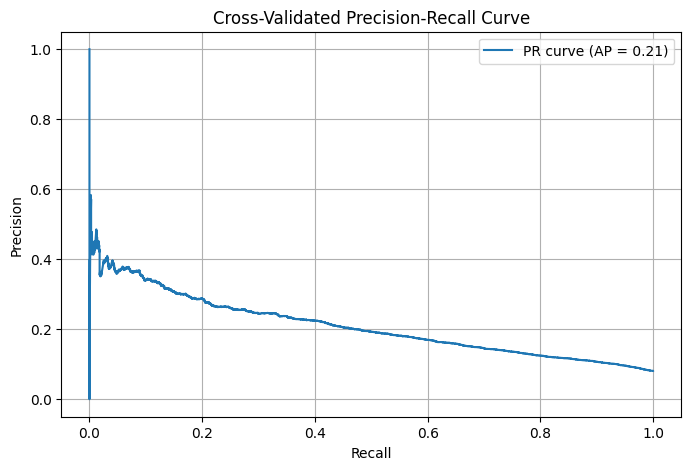

In [72]:
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cross-Validated Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()